# Analysis and visualization notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import sys
import torch
import pandas as pd
import sumolib
import matplotlib.pyplot as plt
import json
import numpy as np

import matplotlib
import matplotlib.colors as mcolors
matplotlib.rcParams.update({'font.size': 16})

In [3]:
sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule
from util_folder.dotdict import DotDict
from util_folder.ml_utils.result_utils.metric_utils import (generate_masks, 
                                                            MetricObj, 
                                                            calc_aggregates, 
                                                            create_res_df, 
                                                            create_test_metrics)
from util_folder.ml_utils.result_utils.plot_utils import plot_classification_errors, plot_net_w_logits, plotNet_colormap_w_norm

In [4]:
def print_res_dict(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            metric_str +=  f'{metric} : {res_dict[loss_part][metric]:.02f} \t'
        print(metric_str)

def print_res_df(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys().get_level_values(0).unique():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            mean = res_dict[loss_part][metric]["mean"]
            std = res_dict[loss_part][metric]["std"]
            metric_str +=  f'{metric} : {mean:.03f} ({std:.03f}) \t'
        print(metric_str)

In [5]:
base_dir = '/home/manity/Quick_adap/quick_adap_to_incidents/saved_models/informed_baseline_comp/'
model_names = os.listdir(base_dir)
model_names = ['inf_dcrnn']
random_seeds = [41,42,43,44]

y_true = torch.load(f'{base_dir}/{model_names[0]}/y_true_{random_seeds[0]}.pt').cpu()

In [6]:
model_paths = [base_dir + 'inf_dcrnn']

In [7]:
results_dict = {}
for i, name in enumerate(model_names):
    results_dict[name] = {}
    for seed in random_seeds:
        results_dict[name][seed] = torch.load(f'{model_paths[i]}/y_hat_{seed}.pt').cpu()
        assert (torch.load(f'{model_paths[i]}/y_true_{seed}.pt').cpu() - y_true).sum() == 0

In [8]:
# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large'
incident_data_module = IncidentDataModule(folder_path = folder_path, batch_size = 100, transform='standardize', spatial_test=False)
incident_data_module.setup()
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

# Generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)

*** DATA SUMMARY: ***
input_obs_full.shape=torch.Size([10270, 147, 6, 10, 3])
input_time_full.shape=torch.Size([10270, 147, 6, 10, 2])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



In [9]:
metric_obj = MetricObj(bce_pos_weight=25.5191)

full_test = {}
for model in model_names:
    full_test[model] = {}
    for seed in random_seeds:
        full_test[model][seed] = metric_obj.calc_metrics(y_hat=results_dict[model][seed], y_true=y_true)
full_test_aggregates = calc_aggregates(full_test, model_names, random_seeds)
full_test_df = create_res_df(full_test_aggregates)
del full_test

upstream_test_df, not_upstream_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, upstream_mask)
multilane_test_df, not_multilane_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, multilane_mask)
highway_test_df, not_highway_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, highway_mask)
spreading_test_df, not_spreading_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, spreading_mask)
affected_test_df, not_affected_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_mask)

In [10]:
n_hop_dfs = {}
for hop in range(11):
    n_hop_mask = (test_dataset.network_info[:,:,0] == -hop)
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, n_hop_mask)
    n_hop_dfs[hop] = temp_df

In [11]:
affected_n_hop_dfs = {}
for hop in range(11):
    affected_n_hop_mask = (test_dataset.network_info[:,:,0] == -hop) & affected_mask
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_n_hop_mask)
    affected_n_hop_dfs[hop] = temp_df

In [12]:
df_arr = [full_test_df,
          upstream_test_df, not_upstream_test_df,
          multilane_test_df, not_multilane_test_df, 
          highway_test_df, not_highway_test_df, 
          spreading_test_df, not_spreading_test_df]


In [13]:
pd.set_option('display.max_rows', 500)
full_test_df.T

mean           std
inf_dcrnn end   mae    2.556521e+00      0.100629
                mape   1.001877e+06  77356.625000
                Mmape  4.878888e-01      0.011920
          start mae    8.719670e-01      0.022980
                mape   3.230272e+05  24012.335938
                Mmape  4.829942e-01      0.031072
          speed mae    7.676415e-01      0.025426
                mape   3.026236e+05  18511.802734
                Mmape  5.022999e-01      0.019142
          class acc    9.471928e-01      0.005140
                f1     5.498592e-01      0.028061
                prcsn  4.147227e-01      0.023823
                rcll   9.633937e-01      0.011511

# Inf_dcrnn

In [14]:
focus_model = model_names[0]

In [15]:
full_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  2.556521  1001876.750  0.487889  0.871967  323027.218750  0.482994   
std   0.100629    77356.625  0.011920  0.022980   24012.335938  0.031072   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.767641  302623.625000  0.502300  0.947193  0.549859  0.414723   
std   0.025426   18511.802734  0.019142  0.005140  0.028061  0.023823   

                
          rcll  
mean  0.963394  
std   0.011511

In [16]:
upstream_test_df[focus_model]

end                             start                          \
            mae          mape     Mmape       mae          mape     Mmape   
mean  16.841446  6.600006e+06  0.487889  5.744206  2.127988e+06  0.482994   
std    0.662907  5.095979e+05  0.011920  0.151382  1.581847e+05  0.031072   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  5.056948  1.993576e+06  0.502300  0.652125  0.549859  0.414723  0.963394  
std   0.167498  1.219492e+05  0.019142  0.033861  0.028061  0.023823  0.011511

In [17]:
not_upstream_test_df[focus_model]

end            start            speed            class                
      mae mape Mmape   mae mape Mmape   mae mape Mmape   acc   f1 prcsn rcll
mean  0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   NaN   1.0  0.0   0.0  0.0
std   0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   NaN   0.0  0.0   0.0  0.0

In [18]:
multilane_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.874003  827007.312500  0.492386  0.994478  274056.718750  0.496038   
std   0.147594   90750.648438  0.016554  0.030982   28271.152344  0.029676   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.873769  250017.687500  0.514499  0.949981  0.626429  0.501313   
std   0.038215   21340.359375  0.024100  0.005860  0.031343  0.030258   

                
          rcll  
mean  0.957349  
std   0.013992

In [19]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.146204  1.227880e+06  0.474506  0.713633  386317.187500  0.444176   
std   0.085337  7.214227e+04  0.028674  0.025984   21973.527344  0.042435   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.630481  370612.125000  0.465995  0.943589  0.404478  0.276234   
std   0.019070   17511.898438  0.008015  0.004242  0.021561  0.014675   

                
          rcll  
mean  0.981381  
std   0.005290

In [20]:
highway_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.091002  1.309790e+06  0.494816  1.070670  424536.500000  0.494774   
std   0.132705  1.039978e+05  0.013680  0.033039   33125.101562  0.029021   

         speed                              class                               
           mae           mape     Mmape       acc        f1     prcsn     rcll  
mean  0.942866  394473.437500  0.508545  0.930966  0.509533  0.374968  0.95771  
std   0.029503   24052.923828  0.023416  0.006602  0.027483  0.022635  0.01363

In [21]:
not_highway_test_df[focus_model]

end                             start                          \
           mae          mape     Mmape       mae          mape     Mmape   
mean  1.672625  492666.90625  0.472174  0.543362  155156.53125  0.456273   
std   0.051721   39343.56250  0.021060  0.008034   11193.81250  0.040109   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.477864  150727.312500  0.488133  0.974028  0.668951  0.542893   
std   0.019072   10517.794922  0.010596  0.002807  0.028989  0.027102   

                
          rcll  
mean  0.976286  
std   0.007438

In [22]:
spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.237894  977127.125000  0.490852  1.123605  324989.937500  0.482405   
std   0.083290   83493.570312  0.013064  0.024873   26978.640625  0.027754   

         speed                              class                               
           mae           mape     Mmape       acc       f1     prcsn      rcll  
mean  0.935557  274607.500000  0.505701  0.950639  0.65810  0.531746  0.962435  
std   0.023965   19153.007812  0.021032  0.005259  0.02853  0.027481  0.011494

In [23]:
not_spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  1.296784  1.047634e+06  0.422096  0.406733  319398.468750  0.496076   
std   0.154718  1.360721e+05  0.055295  0.041511   40115.496094  0.133018   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.457196  354420.437500  0.426768  0.940821  0.119713  0.071827   
std   0.029466   28062.972656  0.027689  0.004934  0.009550  0.005507   

                
          rcll  
mean  0.984694  
std   0.012074

In [24]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  36.758457  0.487889  0.487889  13.118016  0.482994  0.482994  10.981713   
std    1.124443  0.011920  0.011920   0.263333  0.031072  0.031072   0.458330   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.502300  0.502300  0.963394  0.988603   1.0  0.963394  
std   0.019142  0.019142  0.011511  0.004034   0.0  0.011511

In [25]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  1.218068  1.041084e+06   NaN  0.392732  335668.500000   NaN  0.367926   
std   0.094049  8.038380e+04   NaN  0.029194   24952.011719   NaN  0.022506   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  314466.437500   NaN  0.946559  0.0   0.0  0.0  
std    19236.248047   NaN  0.005425  0.0   0.0  0.0

In [26]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.89	 0.81	 0.81	 1.00	 5.43	 20.84	 8.27
1:	 0.79	 0.67	 0.67	 0.99	 5.47	 22.10	 8.28
2:	 0.70	 0.58	 0.55	 0.99	 6.17	 22.59	 8.33
3:	 0.64	 0.54	 0.49	 0.99	 6.71	 23.16	 8.03
4:	 0.60	 0.52	 0.45	 0.99	 7.00	 24.12	 7.86
5:	 0.55	 0.49	 0.40	 0.99	 7.23	 24.99	 7.69
6:	 0.53	 0.48	 0.37	 0.99	 7.60	 25.15	 7.66
7:	 0.51	 0.48	 0.36	 0.99	 8.03	 24.94	 7.52
8:	 0.47	 0.47	 0.33	 0.98	 8.37	 24.27	 7.25
9:	 0.46	 0.49	 0.32	 0.96	 8.84	 24.08	 6.87
10:	 0.43	 0.50	 0.30	 0.96	 9.17	 23.38	 6.38


In [27]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 1.00	 1.00	 1.00	 1.00	 5.19	 19.52	 7.23
1:	 1.00	 0.99	 1.00	 0.99	 5.66	 23.86	 8.09
2:	 1.00	 0.99	 1.00	 0.99	 7.13	 26.92	 9.48
3:	 1.00	 0.99	 1.00	 0.99	 8.46	 29.55	 10.00
4:	 1.00	 0.99	 1.00	 0.99	 9.47	 33.54	 10.59
5:	 1.00	 0.99	 1.00	 0.99	 10.22	 37.10	 11.07
6:	 1.00	 0.99	 1.00	 0.99	 11.79	 39.84	 12.04
7:	 1.00	 0.99	 1.00	 0.99	 14.04	 42.42	 12.96
8:	 1.00	 0.98	 1.00	 0.98	 16.72	 44.77	 14.07
9:	 0.99	 0.96	 1.00	 0.96	 20.16	 49.03	 14.49
10:	 0.99	 0.96	 1.00	 0.96	 24.25	 53.17	 14.91


Text(0.5, 1.0, 'inf_dcrnn')

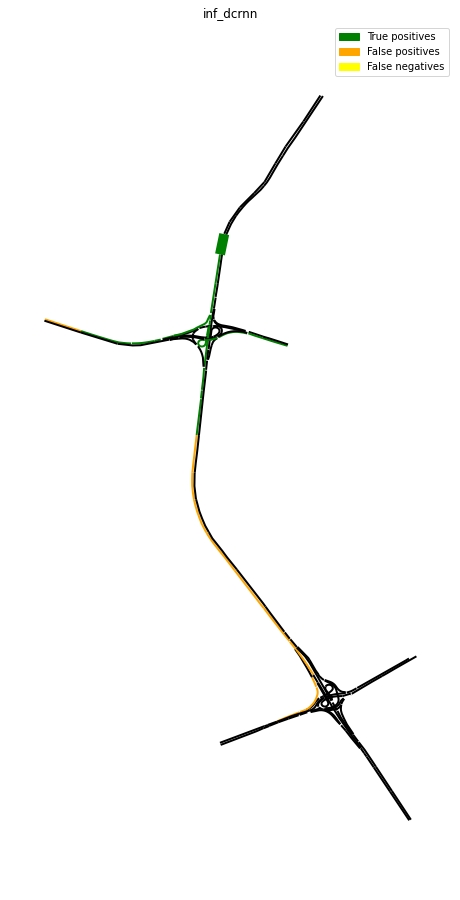

In [28]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'inf_dcrnn')

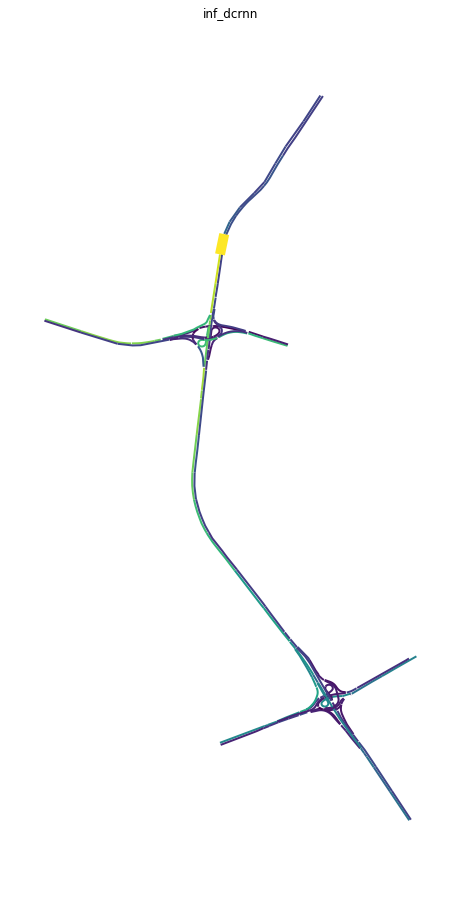

In [29]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'inf_dcrnn')

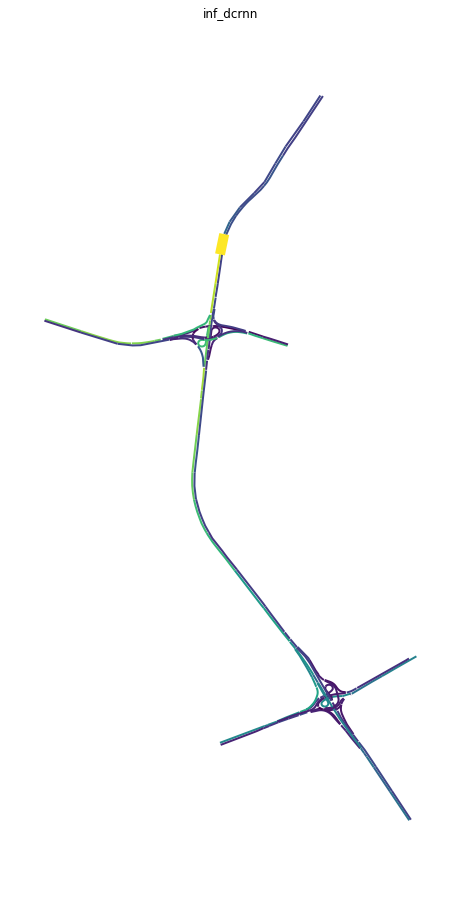

In [30]:

fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

# Res map plots

In [31]:
y_pred = results_dict[focus_model][41]
y_res = y_pred - y_true
seq_num = 6
ie_idx = test_dataset.incident_info[...,0][seq_num].int().numpy()
ie_id = ind_to_edge[str(ie_idx)]
widths = {ie_id:5}
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)
area = {'xmin':500, 'xmax':3200,'ymin':3000, 'ymax':8000}

### Class cong plots

In [32]:
pred_probs = torch.sigmoid(y_pred[seq_num, :, 0])

In [33]:
start_max = np.array([pred_probs.max(), y_true[seq_num, :, 0].max()]).max()
print(start_max)

1.0


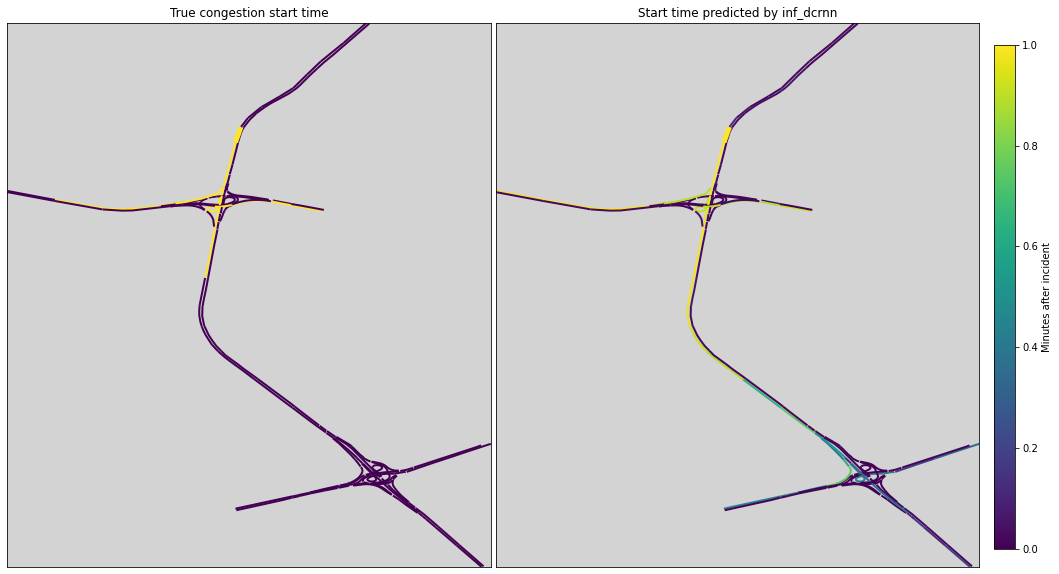

In [34]:
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = 'viridis'

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_true[seq_num,:,1], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[0], 
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax[0].set_title('True congestion start time')
ax[0].set_facecolor('lightgray')
ax[0].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

ax[1], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=pred_probs, 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[1], 
                                        norm=norm,
                                        cmap=cmap,
                                        )
ax[1].set_title(f'Start time predicted by {focus_model}')
ax[1].set_facecolor('lightgrey')
ax[1].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('Minutes after incident')

In [35]:
p = torch.sigmoid(y_pred[seq_num, :, 0])


### START CONG PLOT

In [36]:
start_max = np.array([y_pred[seq_num, :, 1].max(), y_true[seq_num, :, 1].max()]).max()
print(start_max)

28.0


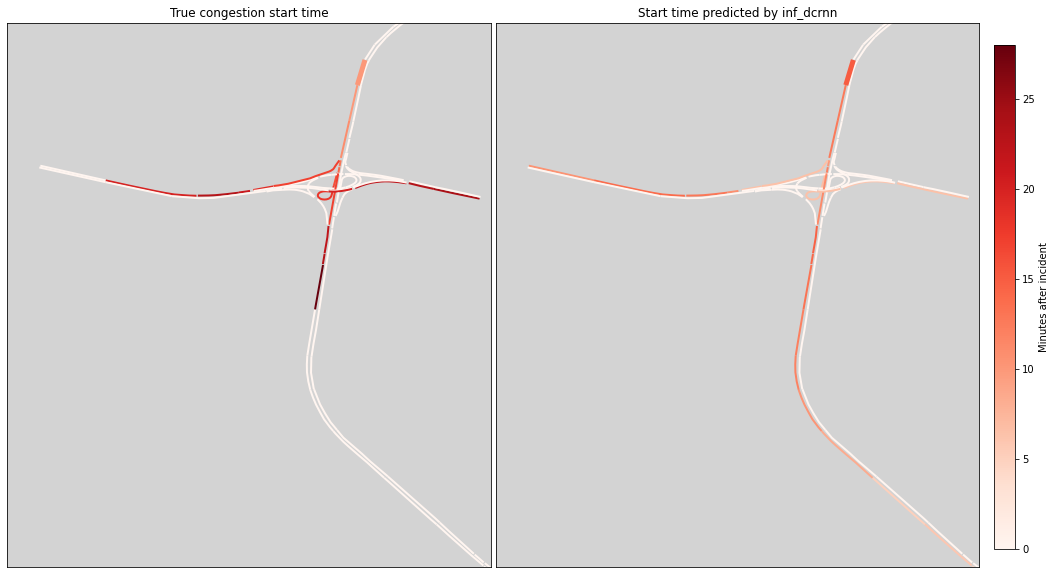

In [37]:
norm = mcolors.Normalize(vmin=0, vmax=start_max)
cmap = 'Reds'

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_true[seq_num,:,1], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[0], 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
ax[0].set_title('True congestion start time')
ax[0].set_facecolor('lightgray')
ax[0].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

ax[1], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_pred[seq_num,:,1], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[1], 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
ax[1].set_title(f'Start time predicted by {focus_model}')
ax[1].set_facecolor('lightgrey')
ax[1].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('Minutes after incident')

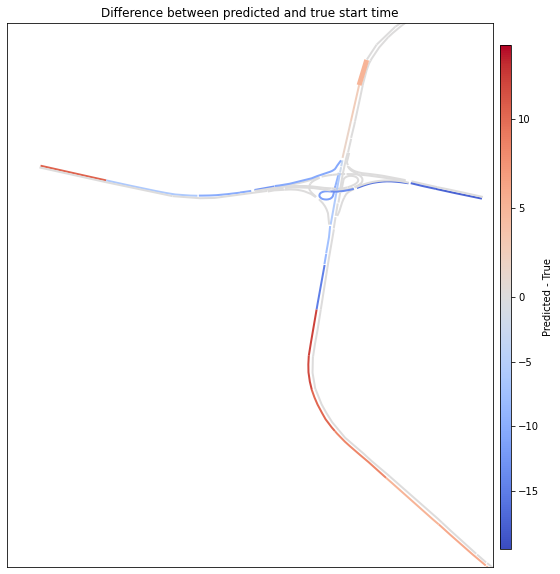

In [38]:
res_min = y_res[seq_num, :, 1].min()
res_max = y_res[seq_num, :, 1].max()
norm = mcolors.TwoSlopeNorm(vmin=res_min - 2, vcenter=0, vmax=res_max + 2)
cmap = 'coolwarm'

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_res[seq_num,:,1], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
ax.set_title('Difference between predicted and true start time')
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('Predicted - True')

# END CONG PLOT

In [39]:
end_max = np.array([y_pred[seq_num, :, 2].max(), y_true[seq_num, :, 2].max()]).max()
print(end_max)

64.34162


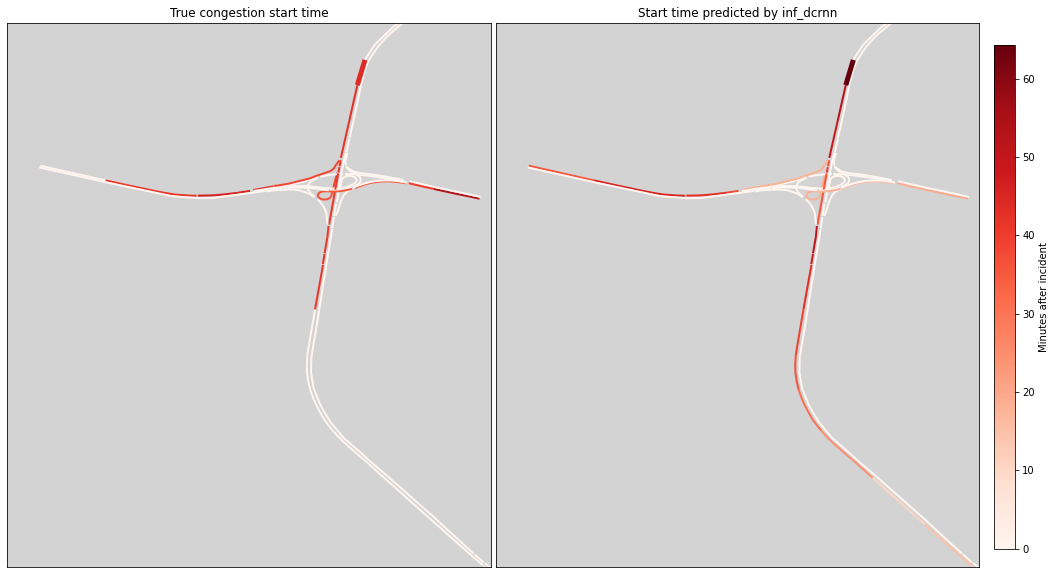

In [40]:
end_max = np.array([y_pred[seq_num, :, 2].max(), y_true[seq_num, :, 2].max()]).max()

norm = mcolors.Normalize(vmin=0, vmax=end_max)
cmap = 'Reds'

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_true[seq_num,:,2], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[0], 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
ax[0].set_title('True congestion start time')
ax[0].set_facecolor('lightgray')
ax[0].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

ax[1], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_pred[seq_num,:,2], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[1], 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
ax[1].set_title(f'Start time predicted by {focus_model}')
ax[1].set_facecolor('lightgrey')
ax[1].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('Minutes after incident')

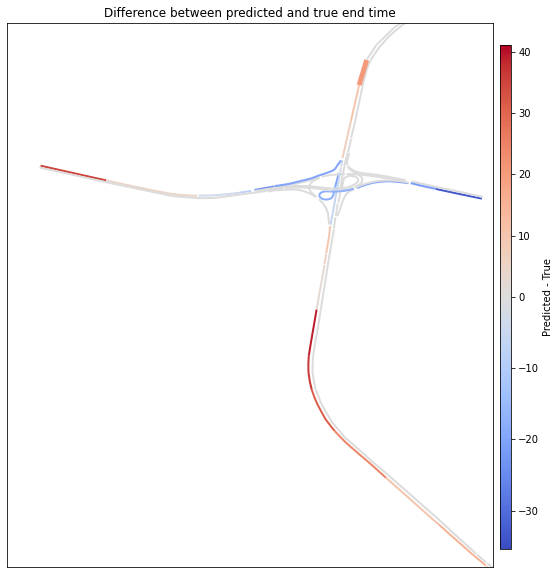

In [41]:
res_min = y_res[seq_num, :, 2].min()
res_max = y_res[seq_num, :, 2].max()

norm = mcolors.TwoSlopeNorm(vmin=res_min - 2, vcenter=0, vmax=res_max + 2)
cmap = 'coolwarm'

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_res[seq_num,:,2], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
#ax[0].set_axis_off()
ax.set_title('Difference between predicted and true end time')
#ax.set_facecolor('lightgray')
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('Predicted - True')

# Speed cong plot

In [42]:
speed_min = np.array([y_pred[seq_num, :, 3].min(), y_true[seq_num, :, 3].min()]).min()
print(speed_min)

-30.52


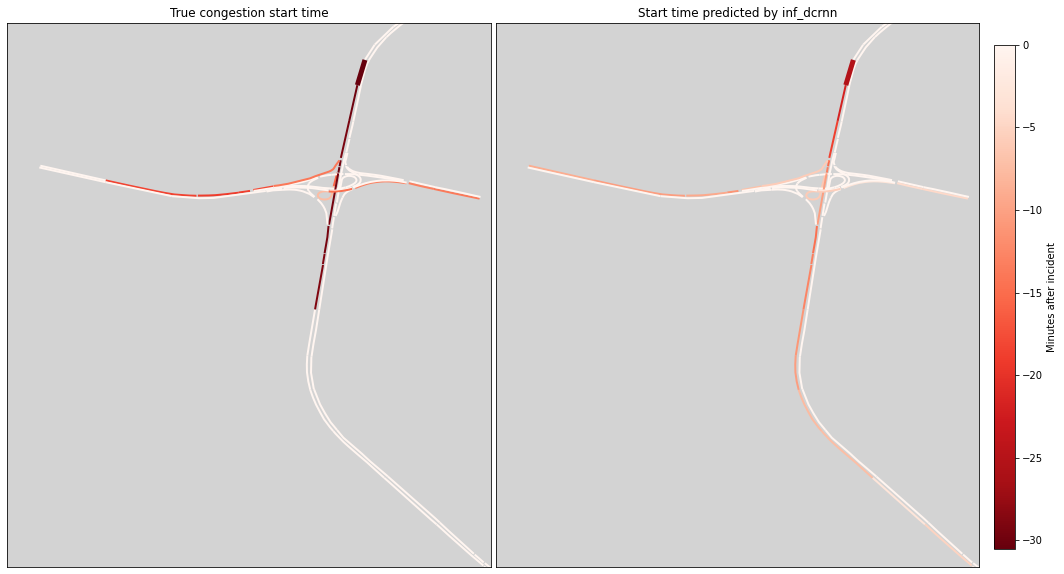

In [43]:
norm = mcolors.Normalize(vmin=speed_min, vmax=0)
cmap = matplotlib.cm.get_cmap('Reds_r')

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_true[seq_num,:,3], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[0], 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
#ax[0].set_axis_off()
ax[0].set_title('True congestion start time')
ax[0].set_facecolor('lightgray')
ax[0].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

ax[1], line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_pred[seq_num,:,3], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax[1], 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
#ax[1].set_axis_off()
ax[1].set_title(f'Start time predicted by {focus_model}')
ax[1].set_facecolor('lightgrey')
ax[1].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('Minutes after incident')

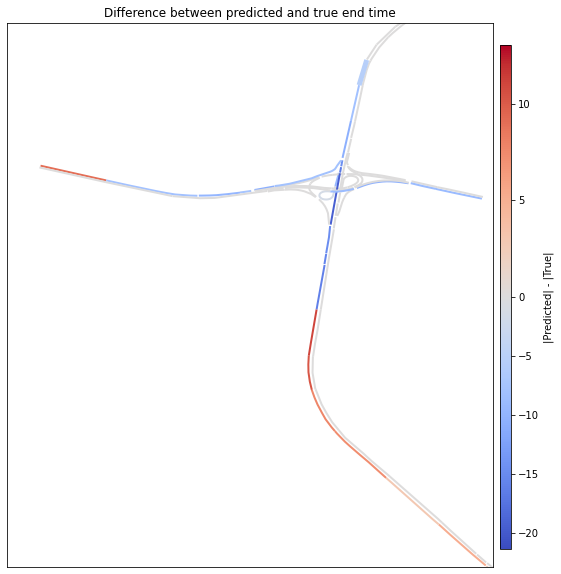

In [44]:
y_res_abs = np.abs(y_pred) - np.abs(y_true)
res_min = y_res_abs[seq_num, :, 3].min()
res_max = y_res_abs[seq_num, :, 3].max()
norm = mcolors.TwoSlopeNorm(vmin=res_min - 2, vcenter=0, vmax=res_max + 2)
cmap = 'coolwarm'

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax, line_segments = plotNet_colormap_w_norm(net=net,
                                        array=y_res_abs[seq_num,:,3], 
                                        widths=widths, 
                                        options=plot_options, 
                                        ax=ax, 
                                        norm=norm,
                                        cmap=cmap,
                                        area=area)
#ax[0].set_axis_off()
ax.set_title('Difference between predicted and true end time')
#ax.set_facecolor('lightgray')
ax.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)

plt.subplots_adjust(wspace=0.01, hspace=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.015, 0.7])
cbar = fig.colorbar(line_segments, cax=cbar_ax)
cbar.set_label('|Predicted| - |True|')

Text(0.5, 1.0, 'False neg')

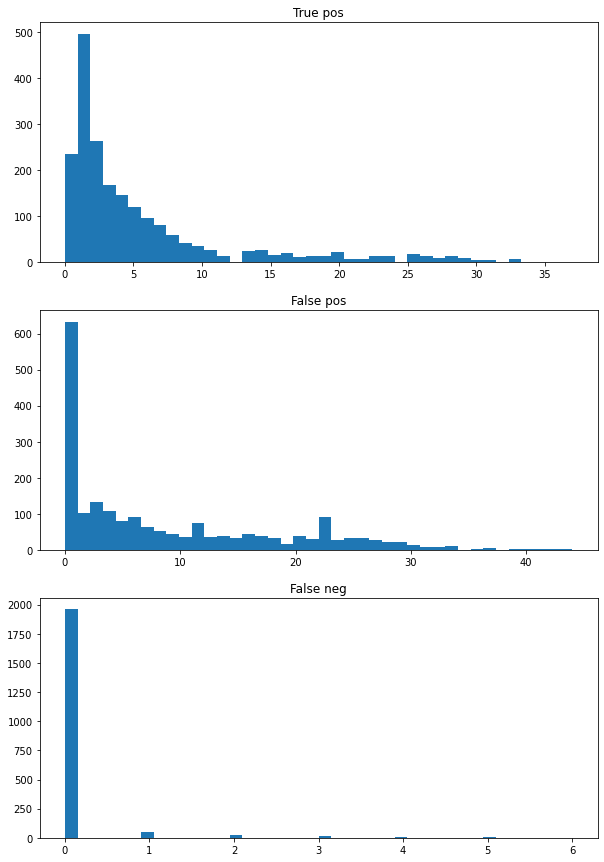

In [45]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=40)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=40)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=40)
ax[2].set_title('False neg')

